# FDL 2019 - Floods

Flooding is a destructive, dangerous, and common hazard. Seventy-five percent of all Presidential disaster declarations are associated with flooding [1]. The work in this memorandum focuses specifically on river flooding. The National Oceanic and Atmospheric Administration's (NOAA's) 13 river forecast centers predict river levels at specific river locations up to several days in advance using hydrologic and hydraulic modeling [1,2]. These forecasts can help cities prepare for and respond to river flooding events in the short-term. The Office of Water Prediction also prepares seasonal water forecasts at regional spatial resolution [3]. The work presented here is complementary to these efforts and explores the efficacy of statistical -- instead of hydrological -- models for the prediction and forecasting of river flooding. 

The scope of this project focuses on two measures of flood susceptibility: predicting whether a specific river gage site will flood in a given month, and the time to peak river level during a flood event. These questions were addressed from two perspectives. The first perspective assumes a well-gaged river basin and seeks to forecast the presence of a flood in the forthcoming month, or the time to peak river level for an ongoing rain event. The second perspective addresses the problem of predicting flood susceptibility in poorly gaged or entirely ungaged river basin. For these experiments, no prior river level information is incorporated into the predictive model. The river level data used to train the statistical models is made possible by the extensive network of stream gages maintained by the US Geological Survey (USGS). Once the models are trained, they are used to construct maps of flood susceptibility, and the most important predictors of flood susceptibility from the statistical models are identified. 

The dataset was collected in 6 states over a period of 10 years between 2009.07-2019.07

Load in ml library and required datasets which include:

    -rainfall data from PRISM
    -Landcover information from NLCD
    -Basin Characteristics
    -Threshold Information per site
    -FLASH Flood data

In [1]:
\l ../../fdl2019/ml/ml.q 
\l ../../fdl2019/ml/init.q
\l ../../fdl2019/ml/fresh/notebooks/graphics.q

\l models.q
\l columns_to_include.q
\l load_data.q

### Cleaning up the Dataset 

All site_no should be updated so that they have at least 8 digits. Any with less will be front loaded with 0's. Any nulls or infinity values from the dataset are also deleted

In [874]:
del:{![x;enlist (=;y;z);0b;`symbol$()]}
conv7_fn:{`$$[7=count x;"0",;]x}
precip:update conv7_fn string each site_no from del[precipall;`ppt;0n]
maxht:update conv7_fn site_no from del[max_ht_str;`height;neg[0w]]

Add in index column for the warnings table (will be used later for nearest neighbours)

In [875]:
warning:update nn:i from warnings

The PRISM dataset had an id limit of 12 digits, which means that some of the site_no digits were excluded. To not lose datapoints when joining, the remaining digits were added back in


In [876]:
rms:asc ds where 12<count each ds:exec distinct string each site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms
matchnames:0!select i by lat,long from precip where i in names[`x][20]
lst1:til[26]except 21 22
lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]
i2:(names[`x]lst2),matchnames`x
precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Seasonal Information plays an important role when predicting if an area will flood and how long it will take which is why the sin and cos of each month of the year is calculated

In [920]:
pi:acos -1
precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip
precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*(month-1)%11,sin_t:sin 2*pi*(month-1)%11 from precip
stryear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:stryear from precip

The inputs to the features are:

prev_col:
       
       -x  = table that's being updated
       -y  = how many previous values to calculate
       -z  = column to apply the function to 
       -gr = what columns to group by
       -col= new column name
       
window_feat:

       -x  = table that's being updated
       -y  = how many previous values to calculate
       -z  = column to apply the function to 
       -wh = where to apply the funtion to 
       -gr = what columns to group by
       -col= new column name
       -w  = ? for select statement, ! for update 

In [921]:
prev_col:   {[x;y;z;gr;col]![x;();gr;$[1<count z;raze;]{raze{(enlist`$string[y],"_",string[x],"_",string[z])
             !enlist (xprev;z;x)}[z;y;]each raze x}[y;col]each z]}
window_feat:{[x;y;z;wh;gr;col;w]w[x;wh;gr;$[1<count z;raze;]{raze{(enlist `$string[y],"_",string[x],"_",string[z])
             !enlist (max;(mavg;z;x))}[z;y;]each raze x}[y;col]each z]}

Knowing the upstream values is also an important feature to include into the dataset. The site_numbers are grouped by the first two digits with the remaining digits in ascending order

In [922]:
catch_site:((';#);2;($:;`site_no))
upstr_ppt:prev_col[precip;1;`ppt;`site_no`date!(catch_site;`date);`upstr]
upstr_height:prev_col[maxht;1;`height;`site_no`date!(catch_site;`date);`upstr]

Get the previous x days of rainfall and stream height for each row in the respective datasets

In [923]:
prev_rain:prev_col[upstr_ppt;enlist 1_til 5;`ppt`upstr_ppt_1;(enlist `site_no)!enlist `site_no;`prev]
all_height:prev_col[upstr_height;enlist 1+til 5;`height`upstr_height_1;(enlist `site_no)!enlist `site_no;`prev]

## Joining the characteristics tables 

Join the basin characteristics to the NLCD landcover dataset based on site_no.

In [924]:
stream_char:nlcd ij`site_no xkey basin

## Target Data

### Monthly Target Data

The gage sites are joined to a flood warning level using nearest neighbours

In [925]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:.ml.clust.kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

In [926]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

In [927]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

For the sake of this project, we only want to predict if the "Flood" level was reached or not for a site during a given month. Our target data is a binary label of whether this was reached or not.

Any site that floods more than 28 days per month is omitted from the dataset

In [928]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time Peak Target Data

After a major rain event, it is important to know how long to will take for the stream to reach peak height.

The FLASH dataset will be used as ground thruth, which highlights how long it will take to reach this peak height, only dates and site numbers used in the rain and height will be extracted.

In [929]:
peak[`delta_peak]:(peak[`peak_time]-peak[`start_time])*24

To predict how long it will take to flood, we have classified this problem as a binary class of whether or not it will take longer than 3 hours. This is important to know how long people have to evacuate from the area when a Flood warning is given.

In [930]:
peak[`target]:peak[`delta_peak]<3.5

## Inputs to the Model

The columns have been divided into three seperate sections:

    -ungaged basin with no perfect forcasts
    -gaged basins with no perfect forcasts
    -gaged basin with perfect forcasts

### Monthly Inputs

When forcasts are provided for each model, knowing how the average rainfall will change over differnet window sizes for each month is a feature that can be added to the dataset.

In [931]:
all_rain:window_feat[prev_rain;enlist 1_til 6;`ppt`upstr_ppt_1;();(`date`site_no)!
         (($;enlist`month;`date);`site_no);`window;!]

The dataset is then broken up into monthly values by taking the first day of each month at a given site

In [932]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data:update date:"m"$date from select from all_rain where 1=`dd$date

Join the stream height and rain data based on site number and month, which is then combined with the basin characteristics and Flood threshold dataset by site number and year

In [933]:
height_rain:height_data ij`site_no`date xkey rain_data
all_monthly_data:(height_rain ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

#### Lagged features

For gaged basins, having knowledge of if an area has flooded in the past or not is also an important feature to extract

In [934]:
all_monthly_data:prev_col[all_monthly_data;enlist 1 12;`target;(enlist `site_no)!enlist `site_no;`lagged]
catch_tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data
all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each?[catch_tgts;();();`no_Flood]

### Time_peak

For the time to peak dataset the day rain and height data is joined to the FLASH dataset based on the site number and date

In [935]:
all_peak_data:((peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height)ij`site_no`year xkey stream_char

#### prev window

To make the times from the stream height dataset consistent with the FLASH dataset, the times have to be changed depending on the time zones

In [936]:
time_zone:raze{dd:x[1];si:x[0];
          select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
          value each 0!select date by distinct site_no from all_peak_data;
all_peak_data:all_peak_data ij`site_no xkey time_zone
change_zone:{$[y=`EDT;neg[04:00]+x;y=`CDT;neg[05:00]+x;neg[06:00]+x]}

In [937]:
all_peak_data[`start_time`peak_time]:change_zone''[;all_peak_data`unk]each all_peak_data[`start_time`delta_peak]

The previous hours before the flood event occurs can show information on how quickly the stream gauge height is moving which can be useful to the model in predicting how long it will take to peak. To do this the 2 days before the event are extracted, and moving averages of different sizes are applied to the stream height dataset

In [938]:
wind_ht_prev:raze{window_feat[str;enlist 2 4 12 48;`height;((within;`date;(,;(+;(-:;2);x[1]);x[1]))
             ;(=;x[0];($;enlist`;`site_no));(within;`datetime;(,;(+;(-:;2);x[2]);x[2])))
             ;0b;`wind_prev;?]}each flip all_peak_data[`site_no`date`start_time]

In [939]:
all_peak_data:all_peak_data,'wind_ht_prev
all_peak_data:del[all_peak_data;`wind_prev_height_2;neg[0w]]

For models that use rain forcasts,knowing what the coming days rainfall will be is also useful to add to the model

In [940]:
rain_pred:raze{window_feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;((within;`date;(,;y[1];(+;y[1];x)));
          (=;y[0];`site_no));0b;`fut_window;?]}[3]each flip all_peak_data[`site_no`date]
all_peak_data:all_peak_data,'rain_pred

## Train Test Split

Delete any rows from the dataset that contains a null

In [1096]:
del_null:{where not any each null x}
cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

In [1105]:
fnd_col:{x where x in y}
ungaged_noforcast_basinM: fnd_col[ungaged_noforcast_basin;cols cleaned_monthly]
gaged_basinM:             fnd_col[gaged_basin;cols cleaned_monthly]
perfect_forcastM:         fnd_col[perfect_forcast;cols cleaned_monthly]
ungaged_noforcast_basinP: fnd_col[ungaged_noforcast_basin;cols cleaned_peak]
gaged_basinP:             fnd_col[gaged_basin;cols cleaned_peak]
perfect_forcastP:         fnd_col[perfect_forcast;cols cleaned_peak]

In [1106]:
ungage: `M`P!(ungaged_noforcast_basinM;ungaged_noforcast_basinP)
gage:   `M`P!(ungage[`M],gaged_basinM;ungage[`P],gaged_basinP)
forcast:`M`P!(gage[`M],perfect_forcastM;gage[`P],perfect_forcastP)

In [1107]:
split_dict:{(!). flip(
  (`ungaged;flip x[ungage[y]]);
  (`gaged;flip x[gage[y]]);
  (`forcast;flip x[forcast[y]]))}

### Monthly 

Split the train and test up by date, so that only past data is contained in the training set. A date was chosen so that 20 percent of the dataset is in the testing set

In [1108]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainM:select from cutoff where date<cutoff
ytrainM:exec target from cutoff where date<cutoff
XtestM:select from cutoff where date>=cutoff
ytestM:exec target from cutoff where date>=cutoff

XtrainM:split_dict[XtrainM;`M]
XtestM:split_dict[XtestM;`M]

### Peak

The time to peak data is seperated so that sites do not appear in both the train and test dataset. To distribution the sum of the target per site is shown below. This distribution is seperated into equeally distributed bins and the train and test split is stratified by this split 

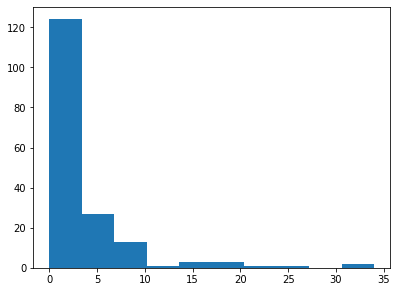

In [1073]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

In [1074]:
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

In [1075]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in `$tts[1]

In [1076]:
XtrainP:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestP:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainP;`P]
XtestP:split_dict[XtestP;`P]

## Run Models

Gradient Boosts and Random forests were applied to the train and test datasets and the results were printed as a precision/recall curve. This metric was chosen as getting a balance between precision and recall when predicting floods is pivitol to ensure that all floods are given warnings but also not too many false warnings are given. The inputs to the pr_curve are

    -Xtest
    -ytest
    -dictionary of models that are being used


In [1077]:
build_model:{[Xtrain;ytrain;x;y]
 rf_clf:      RandomForestClassifier[`n_estimators pykw x;`random_state pykw 0][`:fit][Xtrain; ytrain];
 xgboost_clf: XGBClassifier[`n_estimators pykw y;`learning_rate pykw 0.3;`random_state pykw 0
              ][`:fit][np[`:array]Xtrain; ytrain];
 `random_forest`GBDT!(rf_clf;xgboost_clf)}

## Perfect Forcast


Accuracy for random_forest: 0.9492336
Meanclass accuracy for random_forest: 0.9215411


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.950899  0.9969718 0.9733905 13209  
1        | 0.8921833 0.3273986 0.4790159 1011   
avg/total| 0.9215411 0.6621852 0.7262032 14220  

Accuracy for GBDT: 0.9507805
Meanclass accuracy for GBDT: 0.8774339


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9567725 0.9919752 0.9740559 13209  
1        | 0.7980952 0.4144411 0.5455729 1011   
avg/total| 0.8774339 0.7032082 0.7598144 14220  


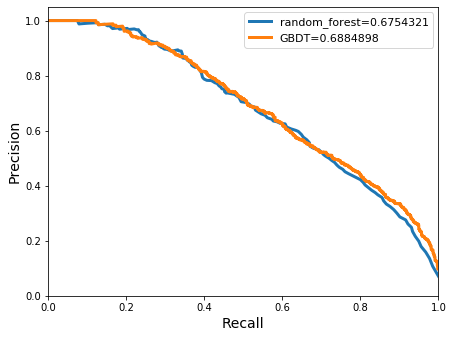

In [863]:
pr_curve[XtestM`forcast;ytestM;build_model[XtrainM`forcast;ytrainM;200;400]]

### Peak Predictions


Accuracy for random_forest: 0.7586207
Meanclass accuracy for random_forest: 0.8424908


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7564103 0.9966216 0.8600583 296    
1        | 0.9285714 0.1203704 0.2131148 108    
avg/total| 0.8424908 0.558496  0.5365865 404    

Accuracy for GBDT: 0.7438424
Meanclass accuracy for GBDT: 0.6688131


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7694444 0.9358108 0.8445122 296    
1        | 0.5681818 0.2314815 0.3289474 108    
avg/total| 0.6688131 0.5836461 0.5867298 404    


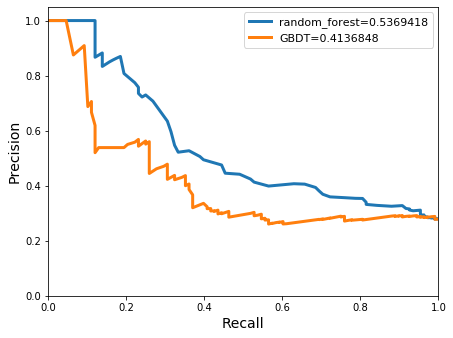

In [1078]:
pr_curve[XtestP`forcast;ytestP;build_model[XtrainP`forcast;ytrainP;150;10]]

## Gaged Prediction

### Monthly Predicts


Accuracy for random_forest: 0.9464921
Meanclass accuracy for random_forest: 0.8921415


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9489889 0.9963602 0.9720977 11539  
1        | 0.8352941 0.2563177 0.3922652 831    
avg/total| 0.8921415 0.6263389 0.6821815 12370  

Accuracy for GBDT: 0.9445522
Meanclass accuracy for GBDT: 0.8299336


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9516518 0.9910737 0.9709628 11539  
1        | 0.7082153 0.3008424 0.4222973 831    
avg/total| 0.8299336 0.6459581 0.6966301 12370  


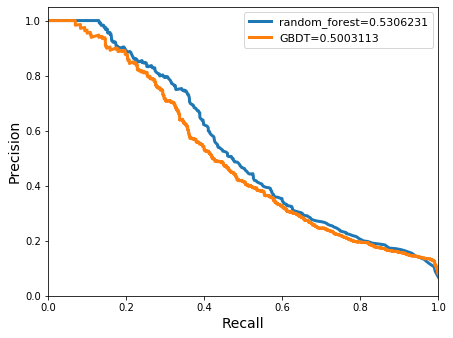

In [595]:
pr_curve[XtestM`gaged;ytestM;build_model[XtrainM`gaged;ytrainM;500;400]]

### Peak Predictions


Accuracy for random_forest: 0.7323689
Meanclass accuracy for random_forest: 0.7582795


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7308448 0.976378  0.8359551 381    
1        | 0.7857143 0.1941176 0.3113208 170    
avg/total| 0.7582795 0.5852478 0.5736379 551    

Accuracy for GBDT: 0.7341772
Meanclass accuracy for GBDT: 0.7929125


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7286822 0.9868766 0.8383501 381    
1        | 0.8571429 0.1764706 0.2926829 170    
avg/total| 0.7929125 0.5816736 0.5655165 551    


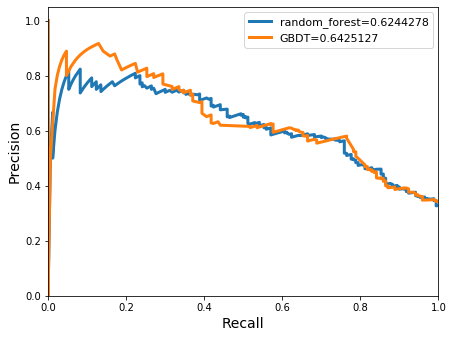

In [521]:
pr_curve[XtestP`gaged;ytestP;build_model[XtrainP`gaged;ytrainP;1500;10]]

## Ungaged Prediction 

### Monthly Predictions


Accuracy for random_forest: 0.9349407
Meanclass accuracy for random_forest: 0.8346482


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.939759  0.9935032 0.9658841 11698  
1        | 0.7295374 0.2157895 0.3330626 950    
avg/total| 0.8346482 0.6046463 0.6494733 12648  

Accuracy for GBDT: 0.9330435
Meanclass accuracy for GBDT: 0.8128107


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9387887 0.9924773 0.9648868 11698  
1        | 0.6868327 0.2031579 0.3135662 950    
avg/total| 0.8128107 0.5978176 0.6392265 12648  


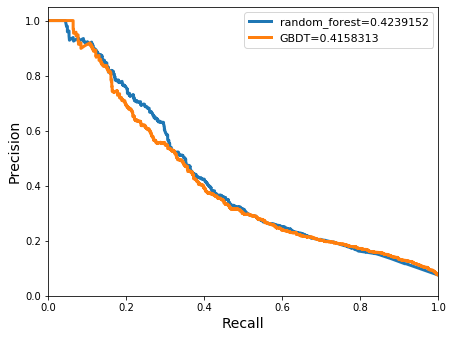

In [1110]:
pr_curve[XtestM`ungaged;ytestM;build_model[XtrainM`ungaged;ytrainM;500;400]]

### Peak Prediction


Accuracy for random_forest: 0.7540687
Meanclass accuracy for random_forest: 0.7569498


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7567568 0.9553806 0.8445476 381    
1        | 0.7571429 0.3117647 0.4416667 170    
avg/total| 0.7569498 0.6335726 0.6431071 551    

Accuracy for GBDT: 0.7631103
Meanclass accuracy for GBDT: 0.753592


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7715517 0.9396325 0.8473373 381    
1        | 0.7356322 0.3764706 0.4980545 170    
avg/total| 0.753592  0.6580516 0.6726959 551    


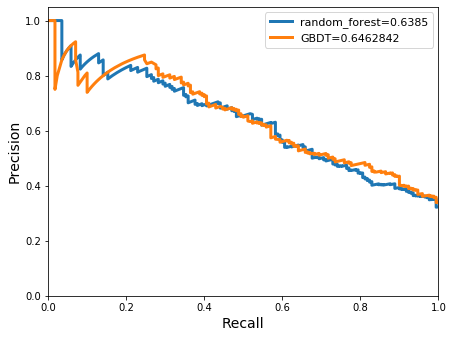

In [784]:
pr_curve[XtestP`ungaged;ytestP;build_model[XtrainP`ungaged;ytrainP;400;50]]

### Feature Significance

In [956]:
"The top 15 significant features in predicting the target values for the monthly predicts are:"
string .ml.fresh.significantfeatures[flip forcast[`M]!cleaned_monthly[forcast[`M]];
 cleaned_monthly`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features in predicting the target values for the mont..


"lagged_target_all"
"window_ppt_1"
"window_ppt_2"
"window_ppt_3"
"window_ppt_4"
"window_ppt_5"
"window_upstr_ppt_1_1"
"window_upstr_ppt_1_2"
"window_upstr_ppt_1_3"
"window_upstr_ppt_1_4"
"lagged_target_12"
"lagged_target_1"
"window_upstr_ppt_1_5"
"elv"
"ElevCat"


In [954]:
"The top 15 significant features in predicting the target values for the time-peak are:"
string .ml.fresh.significantfeatures[flip forcast[`P]!cleaned_peak[forcast[`P]];
 cleaned_peak`target;.ml.fresh.ksigfeat 15]

"The top 15 significant features in predicting the target values for the time..


"WsAreaSqKmRp100"
"WsAreaSqKm"
"wind_prev_height_48"
"prev_upstr_height_1_1"
"wind_prev_height_12"
"prev_height_1"
"prev_height_5"
"WetIndexCat"
"prev_height_4"
"prev_height_2"
"prev_height_3"
"wind_prev_height_4"
"prev_upstr_height_1_5"
"wind_prev_height_2"
"prev_upstr_height_1_2"


## Conclusion

From the above results we can predict with hight accuracy the .............